<div style="background: url(background.jpeg) no-repeat;background-size:cover;
-webkit-mask-image:-webkit-gradient(linear, left top, left bottom, from(rgba(0,0,0,1)), to(rgba(0,0,0,0)));
      mask-image: linear-gradient(to bottom, rgba(0,0,0,1), rgba(0,0,0,0));
  height: 300px;
  width: 100%;
  border: solid 1px #000;
  box-sizing: border-box;
  ">

</div>
<h1 style="text-align:center;top:200px;left:0;right:0;position:absolute;font-weight:900;">Prediktivno Bankarstvo</h1>


In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, mutual_info_classif
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix, log_loss, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from collections import Counter
from itertools import pairwise
from imblearn.combine import SMOTEENN

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', palette='viridis')

In [3]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
numerical = ['duration', 'campaign', 'pdays', 'previous', 'age',
             'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

objects = ['marital', 'education', 'housing', 'default', 'loan',
           'contact', 'month', 'day_of_week', 'poutcome', 'job']

In [5]:
duplicates = df.duplicated()
print('Broj duplikata: %d' % duplicates.sum())

Broj duplikata: 12


In [6]:
df = df.drop_duplicates(keep=False)
duplicates = df.duplicated()
print('Broj duplikata: %d' % duplicates.sum())

Broj duplikata: 0


## Šta raditi sa kategoričkim podacima?

1. **job**
    - imputacija unknown (management ili najfrekventnija)
2. **marital**
    - imputacija single (married)
3. **education**
    - izbaci illiterate (ima ih samo 18) ili ih stavi sve na basic.4y
4. **default**
    - izbaci yes
    - prebaci yes u no
    - izbaci celu kolonu (vrv ovo, jer je sve unknown ili no)
5. **housing**
    - imputacija unknown sa yes (najfrekv)
    - prediktivna imputacija (mozda overkill)
    - samo ostavimo i izbacimo nakon one-hot kodiranja
6. **loan**
    - unknown imputacija u no
7. **month**
    - spojimo sep+oct+nov+dec
    - spojimo apr+mart
8. **poutcome**
    - samo ostavimo i izbacimo non-existant iz one-hot


# Sta raditi sa numerickim kolonama?

1. **campaign**
    - log transform i posle eventualno IQR
2. **age**
    - IQR
3. **duration**
    - log transform pa IQR eventualno
4. **pdays**
    - diskretizuj na 0 i 1 (999 da bude 0 jer to znaci da nije kontaktiran)
5. **previous**
    - diskretizuj na 0 i 1, jer je pramalo ovih koji nisu 0
6. **cons.conf.idx**
    - IQR

-   ostalo ne diramo


## Preprocesiranje


In [7]:
df = df.drop(columns=['default'])  # ok je
# df.loc[df['housing'] == 'unknown', 'housing'] = 'yes'
# df.loc[df['loan'] == 'unknown', 'loan'] = 'no'

In [8]:
# df.loc[df['job'] == 'unknown', 'job'] = 'admin.'
df.loc[df['education'] == 'illiterate', 'education'] = 'basic.4y'  # ok je
# df.loc[df['month'] == 'sep', 'month'] = 'nov'
# df.loc[df['month'] == 'oct', 'month'] = 'nov'
# df.loc[df['month'] == 'dec', 'month'] = 'nov'
# df.loc[df['month'] == 'mar', 'month'] = 'apr'

In [9]:
month_to_quartal = {'jan': 0, 'feb': 0, 'mar': 0,
                    'apr': 1, 'may': 1, 'jun': 1,
                    'jul': 2, 'aug': 2, 'sep': 2,
                    'oct': 3, 'nov': 3, 'dec': 3}

df['year_quartal'] = df['month'].map(month_to_quartal)
df = df.drop('month', axis=1)
print(df['year_quartal'].unique())
df.head()

[1 2 3 0]


,age,job,marital,education,housing,loan,contact,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,year_quartal
0,56,housemaid,married,basic.4y,no,no,telephone,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
1,57,services,married,high.school,no,no,telephone,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
2,37,services,married,high.school,yes,no,telephone,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
3,40,admin.,married,basic.6y,no,no,telephone,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1
4,56,services,married,high.school,no,yes,telephone,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,1


In [10]:
le = LabelEncoder()
df['job'] = le.fit_transform(df['job'])
unknown_job = le.transform(['unknown'])
df['job'] = df['job'].replace(unknown_job, np.nan)

In [11]:
# oe = OrdinalEncoder(categories=[['unknown', 'basic.4y', 'basic.6y', 'basic.9y',
#                     'high.school', 'professional.course', 'university.degree']])
# df['education'] = oe.fit_transform(df['education'].values.reshape(-1, 1))
# unknown_education = oe.transform([['unknown']])
# df['education'] = df['education'].replace(unknown_education, np.nan)

In [12]:
le_edu = LabelEncoder()
df['education'] = le_edu.fit_transform(df['education'])
unknown_job = le_edu.transform(['unknown'])
df['education'] = df['education'].replace(unknown_job, np.nan)

In [13]:
df['housing'] = df['housing'].map({'unknown': np.nan, 'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'unknown': np.nan, 'yes': 1, 'no': 0})
df['y'] = df['y'].map({'no': 0, 'yes': 1})
df['marital'] = df['marital'].map(
    {'unknown': np.nan, 'married': 1, 'single': 0})
df['contact'] = df['contact'].map({'cellular': 1, 'telephone': 0})

In [14]:
df.head()

,age,job,marital,education,housing,loan,contact,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,year_quartal
0,56,3.0,1.0,0.0,0.0,0.0,0,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
1,57,7.0,1.0,3.0,0.0,0.0,0,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
2,37,7.0,1.0,3.0,1.0,0.0,0,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
3,40,0.0,1.0,1.0,0.0,0.0,0,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
4,56,7.0,1.0,3.0,0.0,1.0,0,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1


In [15]:
def remove_outliers_standard_deviation(df, features, n) -> pd.DataFrame:
    outlier_list = []

    for column in features:
        data_mean = df[column].mean()
        data_std = df[column].std()
        cut_off = data_std * 3

        outlier_list_column = df[(
            df[column] < data_mean - cut_off) | (df[column] > data_mean + cut_off)].index
        outlier_list.extend(outlier_list_column)

    return outlier_list

In [16]:
def remove_outliers_iqr(df, features) -> pd.DataFrame:

    outlier_list = []

    for column in features:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)

        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_column = df[(
            df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index

        outlier_list.extend(outlier_list_column)

    return outlier_list

In [17]:
def remove_outliers_isolation_forest(df, contamination='auto',
                                     columns=[]) -> pd.DataFrame:

    clf = IsolationForest(random_state=42, contamination=contamination)

    clf.fit(df[columns])

    y_pred = clf.predict(df[columns])

    outlier_list = df[y_pred == -1].index
    return outlier_list

In [18]:
def log_transform(df, column_name):
    minimum = df[column_name].min()
    df[column_name] = df[column_name]-minimum+1
    df[column_name] = np.log(df[column_name])

In [19]:
for column in ['campaign', 'duration']:
    log_transform(df, column)

In [20]:
df['pdays'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)
df['previous'] = df['previous'].apply(lambda x: 0 if x < 0.5 else 1)

In [21]:
print(f"Pre izbacivanja: {df.shape}")
outliers = remove_outliers_iqr(  # proveriti
    df, ['previous', 'campaign', 'duration', 'pdays', 'age'])
df = df.drop(outliers, axis=0).reset_index(drop=True)
print(f"Nakon izbacivanja: {df.shape}")
print(f"Outliers: {len(outliers)}")
# da li izbaciti previous i pdays?

Pre izbacivanja: (41164, 20)
Nakon izbacivanja: (34115, 20)
Outliers: 8947


In [22]:
# outliers = remove_outliers_isolation_forest(df, contamination=0.1,
#                                             columns=['campaign', 'duration', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'age'])
# df = df.drop(outliers, axis=0).reset_index(drop=True)
# print(f"Izbaceno {len(outliers)} outliera")

In [23]:
# pametniji nacin za age
kbins_discretizer = KBinsDiscretizer(
    n_bins=5, encode='ordinal', strategy='kmeans')
df['age'] = kbins_discretizer.fit_transform(df[['age']])
age_bins = list(pairwise(kbins_discretizer.bin_edges_[0].tolist()))
print(age_bins)  # use for labeling later
df.head()

[(18.0, 30.86664488871721), (30.86664488871721, 38.2908833661116), (38.2908833661116, 46.05213668924405), (46.05213668924405, 53.44333289394748), (53.44333289394748, 69.0)]


,age,job,marital,education,housing,loan,contact,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,year_quartal
0,4.0,3.0,1.0,0.0,0.0,0.0,0,mon,5.568345,0.0,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
1,4.0,7.0,1.0,3.0,0.0,0.0,0,mon,5.010635,0.0,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
2,1.0,7.0,1.0,3.0,1.0,0.0,0,mon,5.424950,0.0,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
3,2.0,0.0,1.0,1.0,0.0,0.0,0,mon,5.023881,0.0,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1
4,4.0,7.0,1.0,3.0,0.0,1.0,0,mon,5.730100,0.0,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,1


In [24]:
df = pd.get_dummies(
    data=df, columns=['day_of_week', 'poutcome']).astype('float64')


df.head()

,age,job,marital,education,housing,loan,contact,duration,campaign,pdays,...,euribor3m,nr.employed,y,year_quartal,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent
0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,5.568345,0.0,0.0,...,4.857,5191.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4.0,7.0,1.0,3.0,0.0,0.0,0.0,5.010635,0.0,0.0,...,4.857,5191.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,7.0,1.0,3.0,1.0,0.0,0.0,5.424950,0.0,0.0,...,4.857,5191.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,2.0,0.0,1.0,1.0,0.0,0.0,0.0,5.023881,0.0,0.0,...,4.857,5191.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,4.0,7.0,1.0,3.0,0.0,1.0,0.0,5.730100,0.0,0.0,...,4.857,5191.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [25]:
imputer = KNNImputer(n_neighbors=1, missing_values=np.nan)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

df.head()

,age,job,marital,education,housing,loan,contact,duration,campaign,pdays,...,euribor3m,nr.employed,y,year_quartal,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent
0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,5.568345,0.0,0.0,...,4.857,5191.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4.0,7.0,1.0,3.0,0.0,0.0,0.0,5.010635,0.0,0.0,...,4.857,5191.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,7.0,1.0,3.0,1.0,0.0,0.0,5.424950,0.0,0.0,...,4.857,5191.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,2.0,0.0,1.0,1.0,0.0,0.0,0.0,5.023881,0.0,0.0,...,4.857,5191.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,4.0,7.0,1.0,3.0,0.0,1.0,0.0,5.730100,0.0,0.0,...,4.857,5191.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [26]:
df['job'] = le.inverse_transform(df['job'].astype(int))
df['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed',
       'entrepreneur', 'student'], dtype=object)

In [27]:
df['education'] = le_edu.inverse_transform(
    df['education'].astype(int))
df['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'university.degree'], dtype=object)

In [28]:
df = pd.get_dummies(
    data=df, columns=['job', 'year_quartal', 'education']).astype('float64')  # probaj sa i bez age i education

df.head()

,age,marital,housing,loan,contact,duration,campaign,pdays,previous,emp.var.rate,...,year_quartal_0.0,year_quartal_1.0,year_quartal_2.0,year_quartal_3.0,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_professional.course,education_university.degree
0,4.0,1.0,0.0,0.0,0.0,5.568345,0.0,0.0,0.0,1.1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4.0,1.0,0.0,0.0,0.0,5.010635,0.0,0.0,0.0,1.1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,5.424950,0.0,0.0,0.0,1.1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.0,1.0,0.0,0.0,0.0,5.023881,0.0,0.0,0.0,1.1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,1.0,0.0,1.0,0.0,5.730100,0.0,0.0,0.0,1.1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
df = df.drop(columns=['poutcome_nonexistent'])

In [30]:
# probaj i norm i std
# scaler = Normalizer()
# cols_to_scale = ['duration',
#                  'campaign', 'emp.var.rate',	'cons.price.idx',	'cons.conf.idx']
# df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
# df.head()

In [31]:
scaler = StandardScaler()
cols_to_scale = ['euribor3m', 'nr.employed', 'duration', 'age',
                 'campaign', 'emp.var.rate',	'cons.price.idx',	'cons.conf.idx']
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
df.head()

,age,marital,housing,loan,contact,duration,campaign,pdays,previous,emp.var.rate,...,year_quartal_0.0,year_quartal_1.0,year_quartal_2.0,year_quartal_3.0,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_professional.course,education_university.degree
0,1.894703,1.0,0.0,0.0,0.0,0.422214,-0.973879,0.0,0.0,0.488206,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.894703,1.0,0.0,0.0,0.0,-0.253348,-0.973879,0.0,0.0,0.488206,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.549162,1.0,1.0,0.0,0.0,0.248518,-0.973879,0.0,0.0,0.488206,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.265459,1.0,0.0,0.0,0.0,-0.237304,-0.973879,0.0,0.0,0.488206,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.894703,1.0,0.0,1.0,0.0,0.618151,-0.973879,0.0,0.0,0.488206,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Isprobavanje modela


In [32]:
# Train test split
X = df.drop('y', axis=1)
y = df['y']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

results = pd.DataFrame(
    columns=["Algorithm", "F1", "AUC", "Accuracy"])

In [34]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [35]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap_base = 'inferno'
vmin, vmax = 0.4, 0.9
cmap = truncate_colormap(cmap_base, vmin, vmax)

In [36]:
def test_models(classifiers, X_train, X_test, y_train, y_test, results):
    sns.set_palette('hls')
    confusion_matrix_fig, confusion_matrix_ax =\
        plt.subplots(1, len(classifiers), figsize=(
            15, 4), constrained_layout=True,)
    all_curves_fig, all_curves_ax = plt.subplots(figsize=(10, 10))
    for i, name in enumerate(classifiers):
        classifier = classifiers[name]
        classifier.fit(X_train, y_train)

        if hasattr(classifier, 'predict_proba'):
            y_pred_prob = classifier.predict_proba(X_test)[:, 1]
        elif hasattr(classifier, 'decision_function'):
            decision_function = classifier.decision_function(X_test)
            y_pred_prob = 1 / (1 + np.exp(-decision_function))
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        print(name+':DONE', end='; ')

        pred = classifier.predict(X_test)
        f1 = f1_score(y_test, pred)
        acc = accuracy_score(y_test, pred)

        row = {'Algorithm': name, 'F1': f1, 'AUC': roc_auc, 'Accuracy': acc}
        results = pd.concat([pd.DataFrame([row]), results], ignore_index=True)

        all_curves_ax.plot(fpr, tpr, lw=2,
                           label=f'{name} (AUC = {roc_auc:.2f})')

        cm = confusion_matrix(y_test, pred)
        ConfusionMatrixDisplay(cm).plot(
            ax=confusion_matrix_ax[i], colorbar=False, cmap=cmap)
        confusion_matrix_ax[i].grid(False)
        confusion_matrix_ax[i].set_title(name)

    all_curves_ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    all_curves_ax.set_title('All ROC Curves')
    all_curves_ax.set_xlabel('False Positive Rate')
    all_curves_ax.set_ylabel('True Positive Rate')
    all_curves_ax.legend(loc='lower right')
    all_curves_fig.show()
    confusion_matrix_fig.show()
    results.sort_values(by='AUC', ascending=False)
    return results

In [37]:
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Ridge': RidgeClassifier(),
}
# results = test_models(classifiers, X_train, X_test, y_train, y_test, results)

Random Forest (balanced):DONE; AdaBoost (balanced):DONE; Bagging (balanced):DONE; Logistic Regression (balanced):DONE; Ridge (balanced):DONE; 

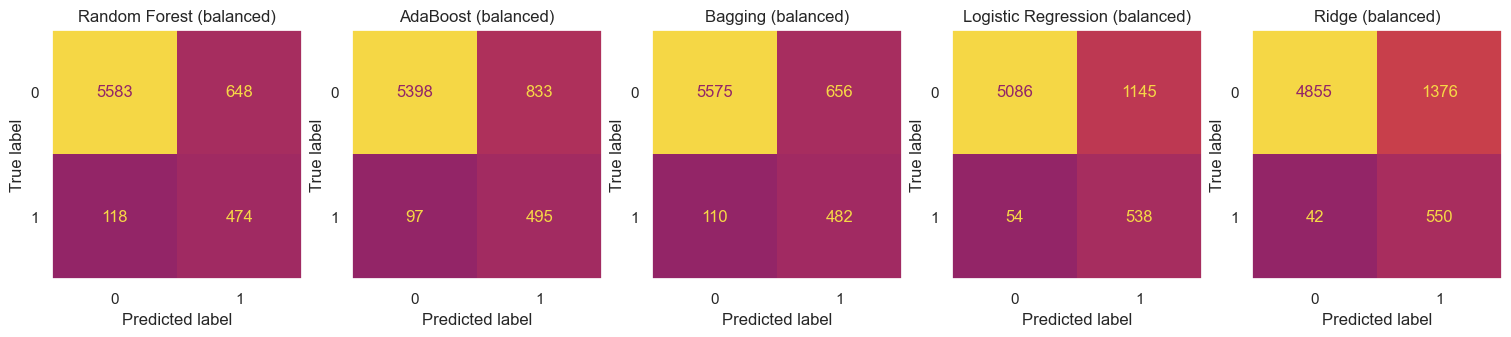

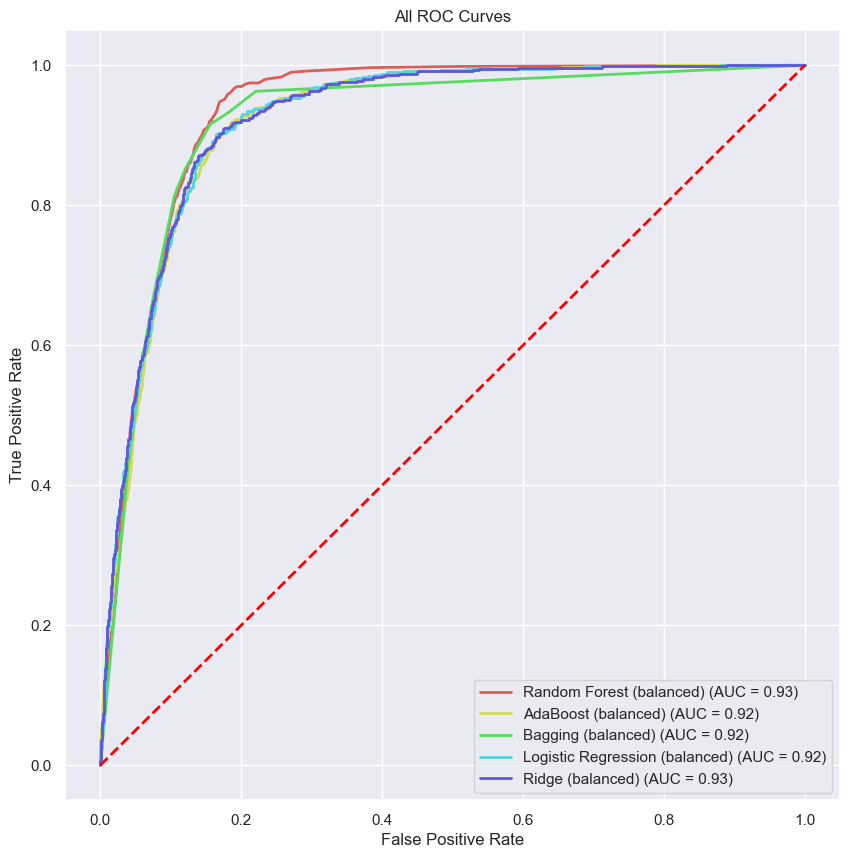

In [38]:
classifiers_balanced = {
    'Random Forest (balanced)': RandomForestClassifier(),
    'AdaBoost (balanced)': AdaBoostClassifier(),
    'Bagging (balanced)': BaggingClassifier(),
    'Logistic Regression (balanced)': LogisticRegression(),
    'Ridge (balanced)': RidgeClassifier(),
}
results = test_models(classifiers_balanced, X_resampled,
                      X_test, y_resampled, y_test, results)

In [39]:
results.sort_values(by='F1', ascending=False)

,Algorithm,F1,AUC,Accuracy
2,Bagging (balanced),0.557225,0.920222,0.887733
4,Random Forest (balanced),0.553092,0.934217,0.887733
3,AdaBoost (balanced),0.515625,0.921608,0.863696
1,Logistic Regression (balanced),0.472967,0.924563,0.824271
0,Ridge (balanced),0.436855,0.925027,0.792174


In [42]:
# hyperparameter tuning
# random forest
rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200,  500],
    'max_depth': [10, None],
    'max_features': ['sqrt'],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=10)
grid_search.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, None], 'max_features': ['sqrt'],
                         'n_estimators': [100, 200, 500]},
             verbose=10)

In [43]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
rf = grid_search.best_estimator_
rf.fit(X_resampled, y_resampled)
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f"F1: {f1}")
print(f"Accuracy: {acc}")

{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 500}
0.9852141765656827
RandomForestClassifier(criterion='entropy', n_estimators=500)
F1: 0.5545350172215844
Accuracy: 0.8862670379598417


In [ ]:
rf.